In [ ]:
# Importing different packages
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
############################ FUNCTIONS #############################
from numpy.random import seed
from numpy.random import randn
from numpy.random import rand
from numpy import append
import matplotlib.pyplot as plt
from numpy import exp
import pandas as pd
from scipy.stats import boxcox
import numpy as np
from numpy import array
from scipy.linalg import svd
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import numpy
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from sklearn.decomposition import PCA
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression, mutual_info_regression
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import FastICA
from sklearn.neighbors import NeighborhoodComponentsAnalysis


##### Removing or Replacing missing values
def missing_values(dataframe, mv_list=[99999]):
	df_withNaN = dataframe
	df_withNaN.iloc[:, range(len(dataframe.columns) - 1)] = df_withNaN.iloc[:, range(len(dataframe.columns) - 1)].replace(mv_list, numpy.NaN)
	# Finding the rows with missing values
	mv_indices = df_withNaN.loc[(df_withNaN.isnull()).any(axis=1), :].index.tolist()
	# Counting missing data in each column
	count_mv = df_withNaN.isnull().sum()
	# Removing missing data
	df_NoNaN = df_withNaN.dropna()
	# Replacing with mean
	df_NaN_to_mean = df_withNaN.fillna(df_withNaN.mean())
	return (df_NoNaN, df_NaN_to_mean, [mv_indices, count_mv])

##### Function for Removing Outliers
def outliers(dataframe, equation='3sigma', sel_cols=[]):
	if len(sel_cols) == 0:
		selected_cols_ind = list(range(len(dataframe.columns) -1))
	else:
		selected_cols_ind = [list(dataframe.columns).index(col) for col in sel_cols]
	colns_with_outliers = []
	indicesList = []
	coln_names = []
	sum_outlier = []
	coln_indices = []
	for i in selected_cols_ind: #range(len(dataframe.columns) - 1):
		if (equation == '3sigma'):
			### Using 3 sigma for outliers 
			outlier_coln = numpy.abs((dataframe.iloc[:, [i]] - (dataframe.iloc[:, [i]].mean())) >  (3 * dataframe.iloc[:, [i]].std()))
			indices_coln = outlier_coln.loc[(outlier_coln == True).any(axis=1), :].index.tolist()
		elif (equation == 'IQRE'):
			#### Using max > Q3 + 1.5(Q3 - Q1) and min < Q1 - 1.5(Q3 - Q1) as outliers
			outlier_max = dataframe.iloc[:, [i]] > (dataframe.iloc[:, [i]].quantile(0.75) + 1.5 * (dataframe.iloc[:, [i]].quantile(0.75) - dataframe.iloc[:, [i]].quantile(0.25)))
			outlier_min = dataframe.iloc[:, [i]] < (dataframe.iloc[:, [i]].quantile(0.25) - 1.5 * (dataframe.iloc[:, [i]].quantile(0.75) - dataframe.iloc[:, [i]].quantile(0.25)))
			indices_max = outlier_max.loc[(outlier_max == True).any(axis=1), :].index.tolist()
			indices_min = outlier_min.loc[(outlier_min == True).any(axis=1), :].index.tolist()
			indices_coln = indices_max + indices_min
		else:
			print('=> Error: Invalid argument entry for equation.')
		coln_names.append(dataframe.columns[i])
		sum_outlier.append(len(indices_coln))
		coln_indices.append(indices_coln)
		if len(indices_coln) > 0:
			colns_with_outliers.append(i)
			indicesList = indicesList + indices_coln
	# Creating dataframes for outlier indices for each column
	outlier_sum_coln = pd.DataFrame({'Column' : coln_names, 'Sum' : sum_outlier})
	df_coln_indices = pd.DataFrame({'Column' : coln_names, 'Outlier_Indices' : coln_indices})
	# Removing duplicate indices
	unique_list = []
	for x in indicesList:
		if x not in unique_list:
			unique_list.append(x)
	# Removing outliers for final preprocessed data
	dataframe_Cleaned = dataframe.drop(unique_list)	# Dataset without both outliers and missing data
	return(dataframe_Cleaned, [colns_with_outliers, outlier_sum_coln, df_coln_indices])

##### Clean data
def clean_data(dataframe, mv_list, output='removeNaN', equation='3sigma', selected_cols=[], details= 'no'):
	df_output = None
	df_remove_NaN, df_replace_NaN, mv_details = missing_values(dataframe, mv_list)
	if (output == 'removeNaN'):
		df_output, out_details = outliers(df_remove_NaN, equation, sel_cols=selected_cols)
	elif (output == 'replaceNaN'):
		df_output, out_details = outliers(df_replace_NaN, equation, sel_cols=selected_cols)	
	else:
		df_output = '=> Error: Invalid input for the argument-output'
	if (details== 'no' and (output == 'removeNaN' or output== 'replaceNaN')):
		print('=> Details of missing values and outliers were opted out. \n')
		#print('* Preprocessed Data:\n')
	elif (details== 'yes' and (output == 'removeNaN' or output== 'replaceNaN')):
		print('#################### Missing Values Details ####################\n')
		print('* Rows or indices with missing values:\n\n', mv_details[0])
		print()
		print('* Sum of missing values per column:\n\nColumn\t\tSum \n', mv_details[1])
		print('\n')
		print('#################### Outliers Details ####################\n')
		print('* Columns with outliers:\n\n', out_details[0])
		print()
		print('* Sum of outliers per column:\n\n', out_details[1])
		print()
		print('* Indices of outlier per column:\n\n', out_details[2])
		print('\n')
		#print('* Preprocessed Data:\n')
	else:
		print('=> Error: Invalid input for the argument-details.\n\n')
		#print('* Preprocessed Data:\n')
	return df_output

# Function for ranking element in a list
def calculate_rank(vector):
  a={}
  rank=1
  for num in sorted(vector):
    if num not in a:
      a[num]=rank
      rank=rank+1
  return[a[i] for i in vector]

# Function for finding top largest numbers in a list
def Nmaxelements(list1, N):
	cnt = 0
	final_list = []
	#list_indices = []
	for i in range(0, N):  
		max1 = 0
		for j in range(len(list1)):      
			if list1[j] > max1: 
				max1 = list1[j] 
		final_list.append(max1)
		#list_indices.append(list1.index(max1))
		list1.remove(max1)
		#cnt += 1
	return final_list

def feature_engineering(dataframe, n_features= 3, transform='PCA', score_fn=chi2, details='no'):
	array = dataframe.values
	X = array[:, 0:(len(array[1])-1)]
	Y = array[:,(len(array[1])-1)]

	### PCA Transformation
	if (transform == 'PCA'):
		pca = PCA(n_features)
		# fit on data
		pca.fit(dataframe.iloc[:, 0:(len(dataframe.columns)-1)])
		B = pca.transform(dataframe.iloc[:, 0:(len(dataframe.columns)-1)])
		pca_det = '''
******** PCA details *********\n
* PCA Components:\n
{0}\n		
* PCA Explained variance:
{1}\n					
* PCA Ratios of explained variance:
{2}\n
* Sum of PCA ratios:
{3}\n
'''.format(pca.components_, [round(elem,6) for elem in (pca.explained_variance_)], [round(elem,6) for elem in (pca.explained_variance_ratio_)], round(sum(pca.explained_variance_ratio_),4))
		if (details == 'yes'):
			print(pca_det)
		elif (details == 'no'):
			print('No request for PCA Details.\n')
		else:
			print('=> Error: Invalid input for the argument-details.\n')
		pca_data = pd.DataFrame(B, columns= ['Component_'+ str(x) for x in range(1,n_features+1)])
		pca_data['D_Variable'] = array[:,(len(array[1])-1)]
		return pca_data

	### Univariate Feature Selection
	elif (transform == 'UFS'):
		# score_func= [chi2, f_classif, mutual_info_classif, f_regression, mutual_info_regression]
		test = SelectKBest(score_func=score_fn, k=n_features)
		fit = test.fit(X, Y)
		# summarize scores
		set_printoptions(precision=3)
		#print(fit.scores_)
		features = fit.transform(X)
		f_scores = fit.scores_
		ufs_det= f'Feature scores:\n\n {f_scores}\n'
		rank_scores = calculate_rank(f_scores) # Full scores ranking list
		rank_scores_reduced = calculate_rank(f_scores) # Reduced scores ranking list due to selecting top N numbers
		ufs_n_largest_f = Nmaxelements(rank_scores_reduced, n_features) # Top N features
		rank_index = [rank_scores.index(x) for x in ufs_n_largest_f] # indices of the N selected features
		ufe_sel_colns = dataframe.columns[rank_index].tolist() # Names of feature or coln names
		ufs_rank_det= f'Feature ranking:\n\n {rank_scores}\n'
		if (details == 'yes'):
			print('******** UFS details *********\n')
			print(ufs_det)
			print(ufs_rank_det)
		elif (details == 'no'):
			print('No request for UFS Details.\n')
		else:
			print('=> Error: Invalid input for the argument-details.\n')
		ufs_data = pd.DataFrame(features, columns= [x for x in ufe_sel_colns])
		ufs_data['D_Variable'] = array[:,(len(array[1])-1)]
		return ufs_data

	### Recurssive Feature Elimination
	elif (transform == 'RFE'):
		model = LogisticRegression(solver='lbfgs', max_iter=1000)
		rfe = RFE(model, n_features)
		fit = rfe.fit(X, Y)
		rfe_det1= f'Selected Features:\n\n {fit.support_}\n'
		rfe_det2= f'Feature Ranking:\n\n {fit.ranking_}\n'
		rfe_rank_list = fit.ranking_.tolist()
		sel_att_indices = []
		count = 0
		for x in rfe_rank_list:
			if x == 1:
				sel_att_indices.append(count)
			count += 1	
		rfe_sel_coln = dataframe.columns[sel_att_indices].tolist()
		rfe_sel_coln.append(dataframe.columns[len(dataframe.columns)-1])
		if (details == 'yes'):
			print('******** RFE details *********\n')
			print(rfe_det1)
			print(rfe_det2)
		elif (details == 'no'):
			print('No request for RFE Details.\n')
		else:
			print('=> Error: Invalid input for the argument-details.\n')
		rfe_data = dataframe[rfe_sel_coln]
		return rfe_data

	### Feature Importance Extraction
	elif (transform == 'FIE'):
		model = ExtraTreesClassifier()
		model.fit(X, Y)
		fie_scores = model.feature_importances_
		fie_rank = calculate_rank(fie_scores)
		fie_rank_reduced = calculate_rank(fie_scores)
		fie_det1= f'Feature Importance:\n\n {fie_scores}\n'
		fie_det2= f'Feature Ranking:\n\n {fie_rank}\n'
		fie_n_largest_f = Nmaxelements(fie_rank_reduced, n_features)
		fie_sel_index = [fie_rank.index(x) for x in fie_n_largest_f]
		fie_sel_cols = dataframe.columns[fie_sel_index].tolist()
		fie_sel_cols.append(dataframe.columns[len(dataframe.columns)-1])
		if (details == 'yes'):
			print('******** FIE details *********\n')
			print(fie_det1)
			print(fie_det2)
		elif (details == 'no'):
			print('No request for FIE Details.\n')
		else:
			print('=> Error: Invalid input for the argument-details.\n')
		fie_data = dataframe[fie_sel_cols]
		return fie_data

	### Independent Component Analysis
	elif (transform == 'ICA'):
		ica = FastICA(n_components=n_features, random_state=0)
		ica.fit(X, Y)
		ica_transf_X = ica.transform(X)
		ica_det= '''
******** ICA Details *********\n
* ICA Number of Iterations:\n
{0}\n		
* ICA Components:\n
{1}\n					
* ICA Mixing Matrix:\n
{2}\n
'''.format(ica.n_iter_, ica.components_, ica.mixing_)
		if (details == 'yes'):
			print(ica_det)
		elif (details == 'no'):
			print('No request for ICA Details.\n')
		else:
			print('=> Error: Invalid input for the argument-details.\n')
		ica_data = pd.DataFrame(ica_transf_X, columns= ['Component_'+ str(x) for x in range(1,n_features+1)])
		ica_data['D_Variable'] = array[:,(len(array[1])-1)]
		return ica_data

#	### Neighborhood Component Analysis
#	elif (transform == 'NCA'):
#		nca = NeighborhoodComponentsAnalysis(n_components=n_features, random_state=42)
#		nca = nca.fit(X, Y)
#		nca_transf_X = nca.transform(X)
#		nca_det= '''
#******** NCA Details *********\n
#* NCA Number of Iterations:\n
#{0}\n		
#* NCA Components:\n
#{1}\n					
#'''.format(nca.n_iter_, nca.components_)
#		if (details == 'yes'):
#			print(nca_det)
#		elif (details == 'no'):
#			print('No request for NCA Details.\n')
#		else:
#			print('=> Error: Invalid input for the argument-details.\n')
#		nca_data = pd.DataFrame(nca_transf_X, columns= ['Component_'+ str(x) for x in range(1,n_features+1)])
#		nca_data['D_Variable'] = array[:,(len(array[1])-1)]
#		return nca_data
#
#	### When the input for the argument transform is invalid
#	else:
#		print('=> Error: Invalid input for the argument-details or transform.\n\n')
#	

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
#@title Example form fields
#@markdown Forms support many types of fields.

no_type_checking = ''  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 142  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotAllowedError: The request is not allowed by the user agent or the platform in the current context.


In [ ]:
# Importing the details about the Wisconsin Breast Cancer
wbc_text_url = "https://raw.githubusercontent.com/eadadzie/Tech_Talent_South-AC_Data_Science/master/PROJECT/2_ML_Project/Datasets/Breat_cancer_Wisconsin/w_prog_bc.txt"
page_wbc = requests.get(wbc_text_url)
print(page_wbc.text)


1. Title: Wisconsin Prognostic Breast Cancer (WPBC)

2. Source Information

a) Creators: 

	Dr. William H. Wolberg, General Surgery Dept., University of
	Wisconsin,  Clinical Sciences Center, Madison, WI 53792
	wolberg@eagle.surgery.wisc.edu

	W. Nick Street, Computer Sciences Dept., University of
	Wisconsin, 1210 West Dayton St., Madison, WI 53706
	street@cs.wisc.edu  608-262-6619

	Olvi L. Mangasarian, Computer Sciences Dept., University of
	Wisconsin, 1210 West Dayton St., Madison, WI 53706
	olvi@cs.wisc.edu 

b) Donor: Nick Street

c) Date: December 1995

3. Past Usage:

	Various versions of this data have been used in the following
	publications: 

	(i) W. N. Street, O. L. Mangasarian, and W.H. Wolberg. 
	An inductive learning approach to prognostic prediction. 
	In A. Prieditis and S. Russell, editors, Proceedings of the
	Twelfth International Conference on Machine Learning, pages
	522--530, San Francisco, 1995. Morgan Kaufmann.

	(ii) O.L. Mangasarian, W.N. Street and W.H. Wolbe

In [ ]:
# Importing the Wisconsin Breast Cancer datasets
headers_bc = []
df_wbc = pd.read_csv("https://raw.githubusercontent.com/eadadzie/Tech_Talent_South-AC_Data_Science/master/PROJECT/2_ML_Project/Datasets/Breat_cancer_Wisconsin/w_prog_bc.csv", header=None)
# print(df_wbc)
# print()


In [ ]:
# Importing the details about the Wine Datasets
wine_text_url = "https://raw.githubusercontent.com/eadadzie/Tech_Talent_South-AC_Data_Science/master/PROJECT/2_ML_Project/Datasets/Wine_Quality/winequality.txt"
# page_wine = requests.get(wine_text_url)
# print(page_wine.text)

In [ ]:
# Importing the Wine data
df_wine = pd.read_csv("https://raw.githubusercontent.com/eadadzie/Tech_Talent_South-AC_Data_Science/master/PROJECT/2_ML_Project/Datasets/Wine_Quality/winequality-red.csv")
# print(df_wine)
# print()

In [ ]:
##### Importing the details about the Students' Performance
student_text_url = "https://raw.githubusercontent.com/eadadzie/Tech_Talent_South-AC_Data_Science/master/PROJECT/2_ML_Project/Datasets/Students_performance/student.txt"
page_student = requests.get(student_text_url)
print(page_student.text)

# Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2 sex - student's sex (binary: "F" - female or "M" - male)
3 age - student's age (numeric: from 15 to 22)
4 address - student's home address type (binary: "U" - urban or "R" - rural)
5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or 

In [ ]:
# Importing the Student data

#print('*** Datasets on Math\n')
df_student_mat = pd.read_csv("https://raw.githubusercontent.com/eadadzie/Tech_Talent_South-AC_Data_Science/master/PROJECT/2_ML_Project/Datasets/Students_performance/student-mat.csv", delimiter=";")
df_student_mat.insert(1, "course", "Math")
#print(df_student_mat)
print()

#print('*** Datasets on Portugese\n')
df_student_port = pd.read_csv("https://raw.githubusercontent.com/eadadzie/Tech_Talent_South-AC_Data_Science/master/PROJECT/2_ML_Project/Datasets/Students_performance/student-por.csv", delimiter=";")
df_student_port.insert(1, "course", "Portuguese")
#print(df_student_port)
print()

# Combined data from both subject courses
print('*** Full Student Datasets\n')
df_student = df_student_mat.append(df_student_port)
print(df_student)
print()





*** Full Student Datasets

    school      course sex  age address  ... health absences  G1  G2  G3
0       GP        Math   F   18       U  ...      3        6   5   6   6
1       GP        Math   F   17       U  ...      3        4   5   5   6
2       GP        Math   F   15       U  ...      3       10   7   8  10
3       GP        Math   F   15       U  ...      5        2  15  14  15
4       GP        Math   F   16       U  ...      5        4   6  10  10
..     ...         ...  ..  ...     ...  ...    ...      ...  ..  ..  ..
644     MS  Portuguese   F   19       R  ...      5        4  10  11  10
645     MS  Portuguese   F   18       U  ...      1        4  15  15  16
646     MS  Portuguese   F   18       U  ...      5        6  11  12   9
647     MS  Portuguese   M   17       U  ...      2        6  10  10  10
648     MS  Portuguese   M   18       R  ...      5        4  10  11  11

[1044 rows x 34 columns]



In [ ]:
##### EXPLORATORY DATA ANALYSIS - DETAILS OF DATASETS

### Details of the data
print("*** Details of Dataset\n")
print(df_student.info())
print("\n")

### Capture all categorical varibles and get their unique values
print("*** Unique values in categorical variables\n")

col_unique_vals = {}
for col in df_student.columns:
  if df_student[col].dtypes == object:
    col_unique_vals[col] = df_student[col].unique()
    if len(col) <= 4:
      print(col, "\t:\t", df_student[col].unique())
    else:
      print(col, ":\t", df_student[col].unique())

#print("Unique Values:\n", col_unique_vals)
print("\n")

### Checking Missing Values
print("*** Missing Values\n")
print(df_student.isnull().sum())
print("\n")

### Descriptive Stats of Continues variables
print("*** Descriptive Stats\n")
print(df_student.describe())
print("\n")

*** Details of Dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   course      1044 non-null   object
 2   sex         1044 non-null   object
 3   age         1044 non-null   int64 
 4   address     1044 non-null   object
 5   famsize     1044 non-null   object
 6   Pstatus     1044 non-null   object
 7   Medu        1044 non-null   int64 
 8   Fedu        1044 non-null   int64 
 9   Mjob        1044 non-null   object
 10  Fjob        1044 non-null   object
 11  reason      1044 non-null   object
 12  guardian    1044 non-null   object
 13  traveltime  1044 non-null   int64 
 14  studytime   1044 non-null   int64 
 15  failures    1044 non-null   int64 
 16  schoolsup   1044 non-null   object
 17  famsup      1044 non-null   object
 18  paid        1044 non-null   object
 19  activities  1044 non-null

*** Histogram Plot


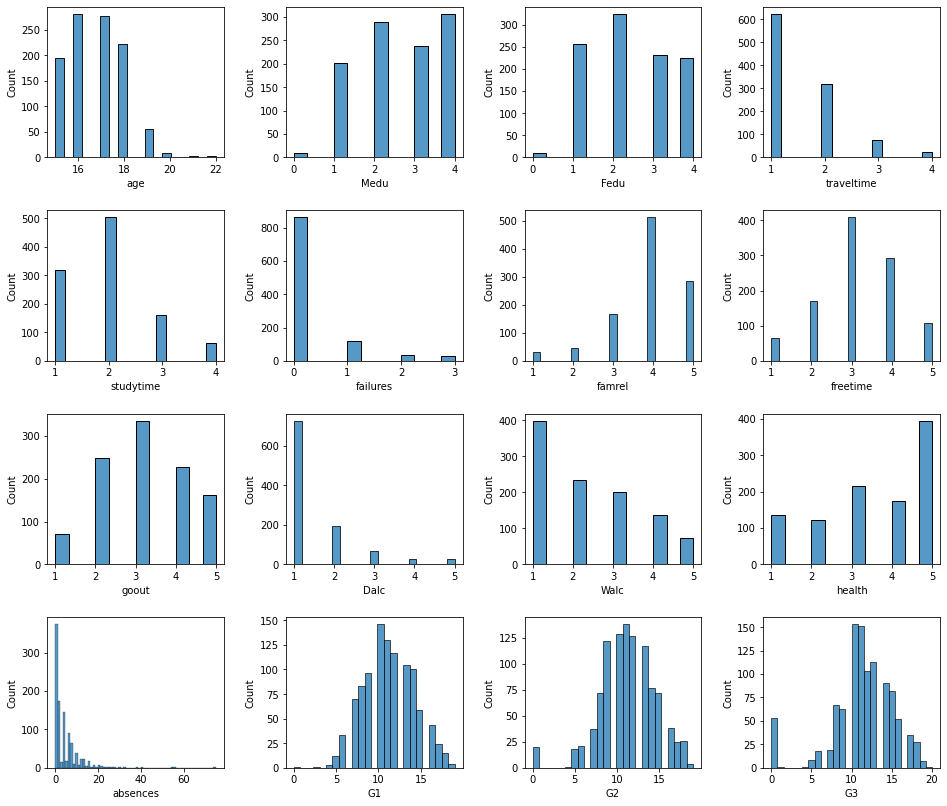



*** Factor Plots


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


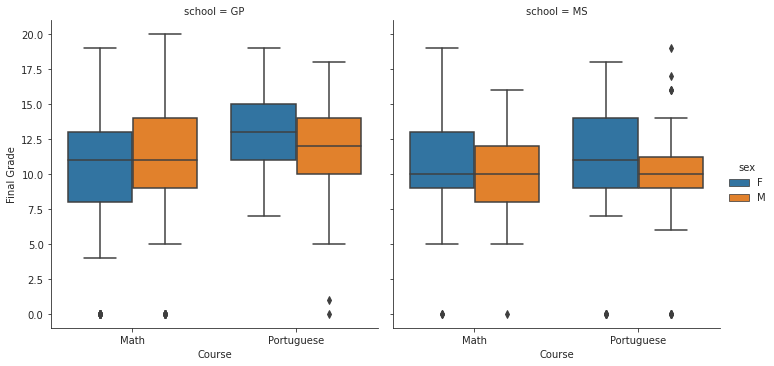

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


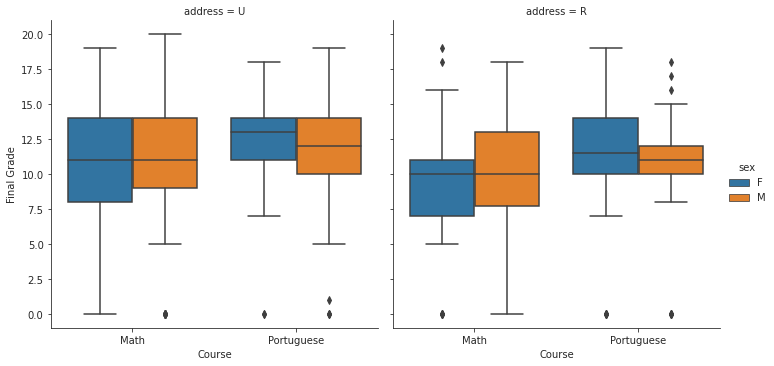

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


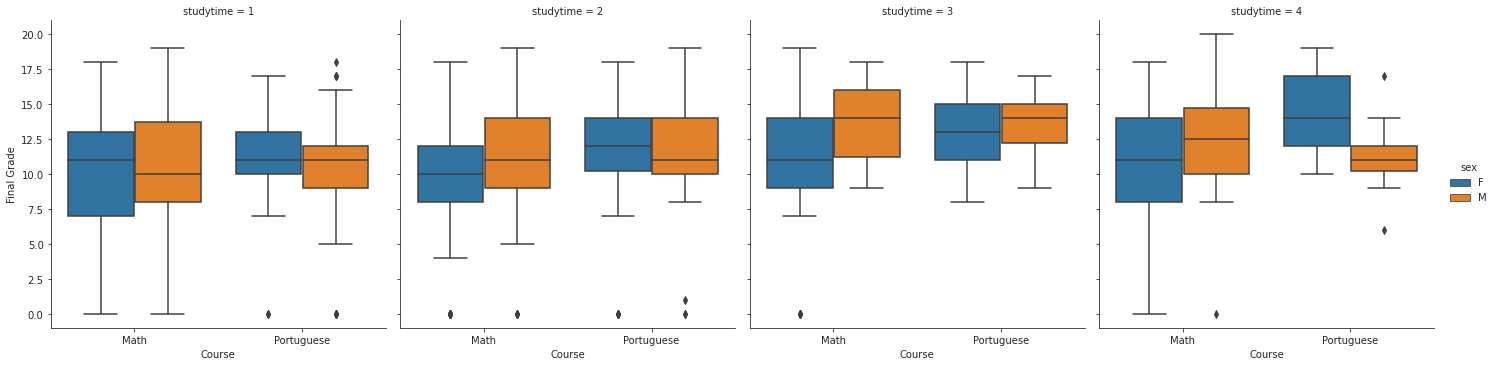

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


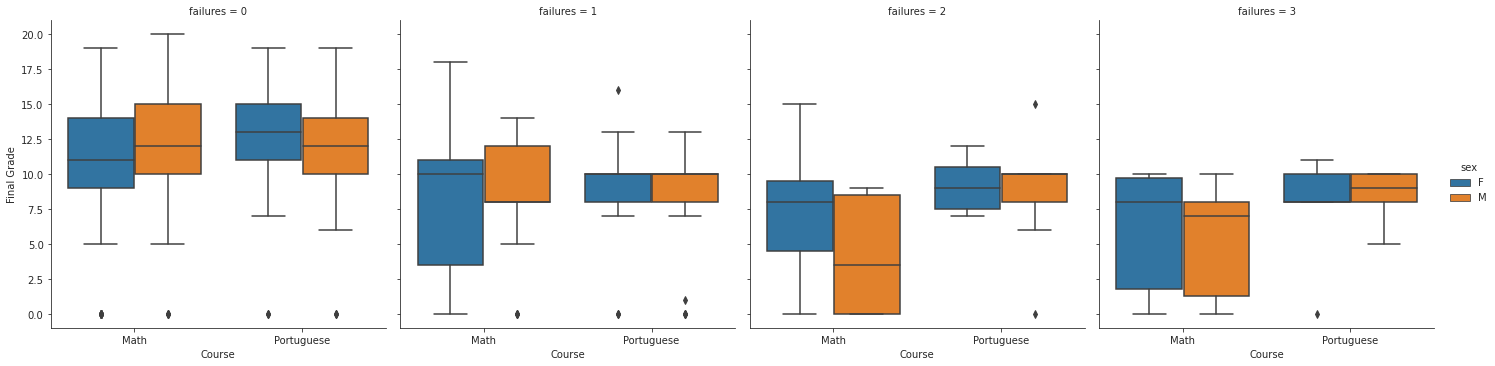

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


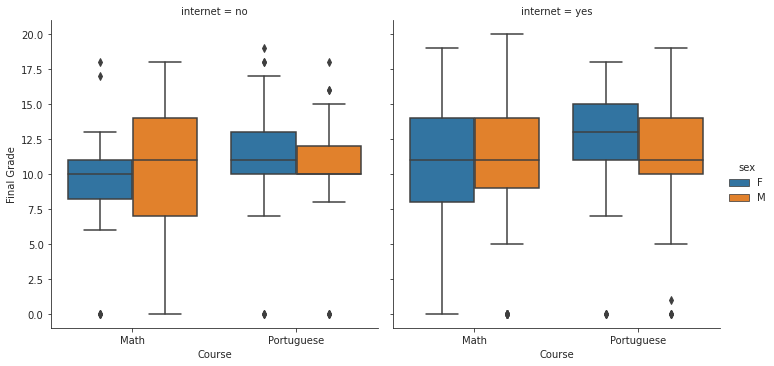




*** Pair Plots


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


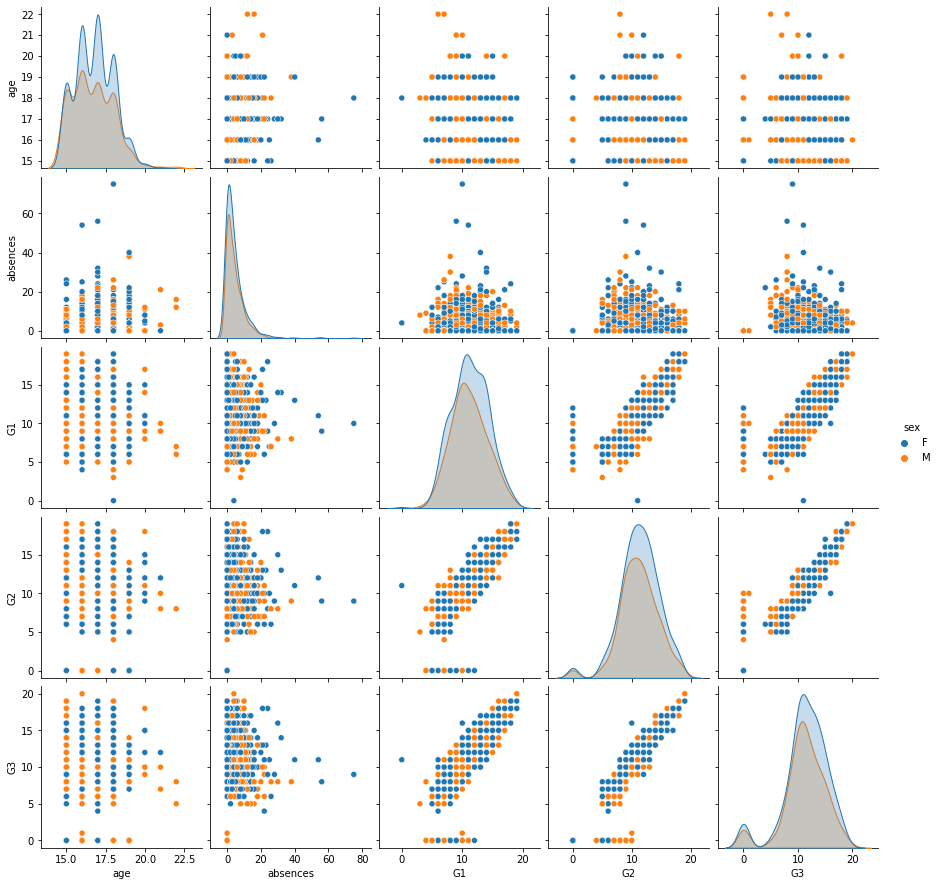



*** Correlation Matrix


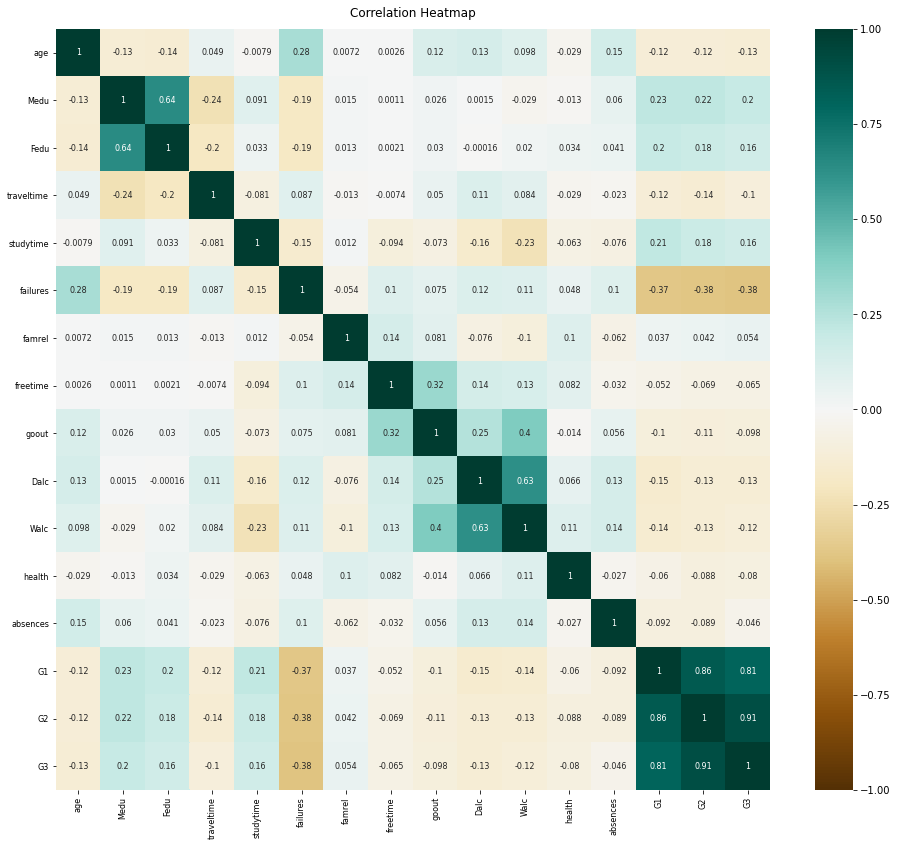

In [ ]:
##### EXPLORATORY DATA ANALYSIS - VISUALIZATION

num_variables = [name for name in df_student.columns if df_student[name].dtypes == int]
#print(num_variables)

### Plotting Histogram
print("*** Histogram Plot")
count = 0
n_rows = 4
n_cols = 4
fig, axes=plt.subplots(n_rows, n_cols, figsize=(16,14), sharex=False, gridspec_kw={'hspace': 0.35, 'wspace': 0.35})
for i in range(len(num_variables)):
  sns.histplot(df_student[num_variables[i]], ax=axes[i//n_cols, i%n_cols])
  count += 1
plt.show()
print("\n")

### Plotting Factor Plots
print("*** Factor Plots")
## Considering Five Factors
third_factor = ["school", "address", "studytime", "failures", "internet"]
# Looping through the factors
for factor in third_factor:
  with sns.axes_style(style='ticks'):
      g = sns.factorplot(x="course", y="G3", hue="sex", col= factor, data=df_student, kind="box")
      g.set_axis_labels("Course", "Final Grade");
  plt.show()
  print()
print("\n")

### Plotting Pair Plots
print("*** Pair Plots")
sns.pairplot(df_student[["age", "absences", "G1", "G2", "G3","sex"]], hue='sex', size=2.5);
plt.show()
print("\n")

### Plotting Correlation Matrix
print("*** Correlation Matrix")

fig1, ax1 = plt.subplots(figsize=(16,14))
#matrix = np.triu(df.corr())
ax1 = sns.heatmap(df_student.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=None, annot_kws={"size":8})
ax1.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 8, rotation=90)
ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 8, rotation=0)
plt.show()


In [ ]:
##### EXPLORATORY DATA ANALYSIS - PREPROCESSING AND FEATURE ENGINEERING

### Clean Data
df_student_clean = clean_data(df_student, mv_list=[99999], output='removeNaN', equation='IQRE', selected_cols=["age", "absences", "G1", "G2", "G3"], details= 'yes')
print("*** Clean Data\n", df_student_clean)
print("\n")

### Transform Data

### Extract or Select Features


#################### Missing Values Details ####################

* Rows or indices with missing values:

 []

* Sum of missing values per column:

Column		Sum 
 school        0
course        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


#################### Outliers Details ####################

* Columns with outliers:

 [3, 30, 31, 32, 33]

* Sum of outliers per column:

      Column  Sum
0       age    2
1  absences   54
2        G1    1
3        G2   20
4        G3   54

* Indices of outlier per column:

  

*** Histogram Plot


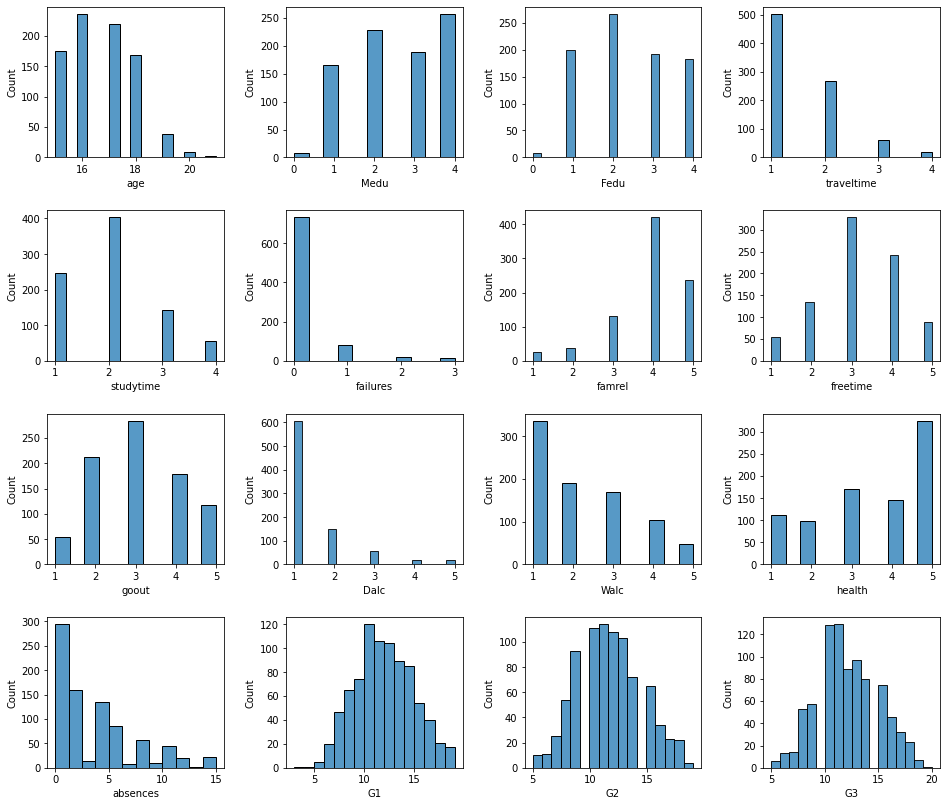



*** Factor Plots


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


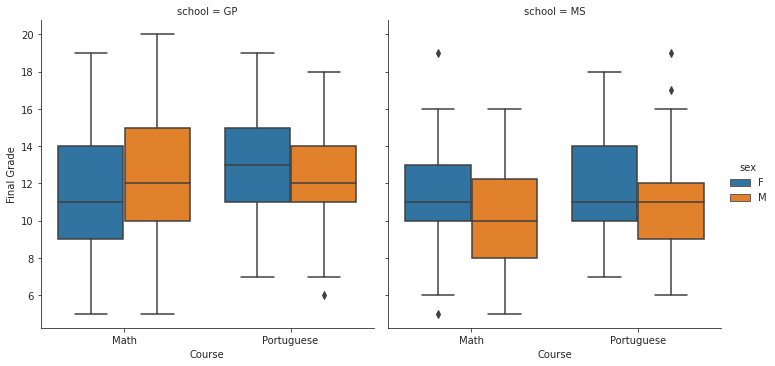

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


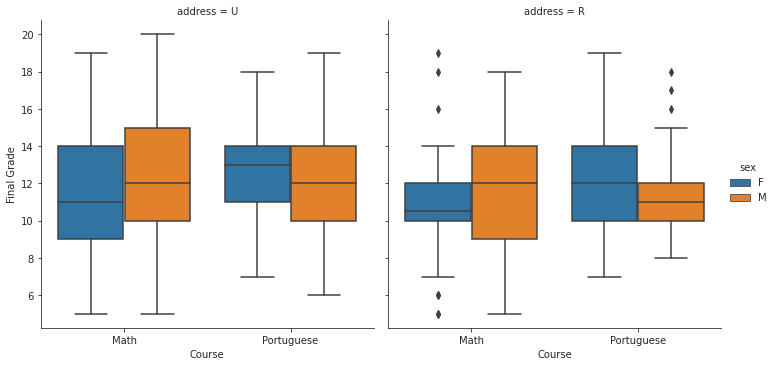

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


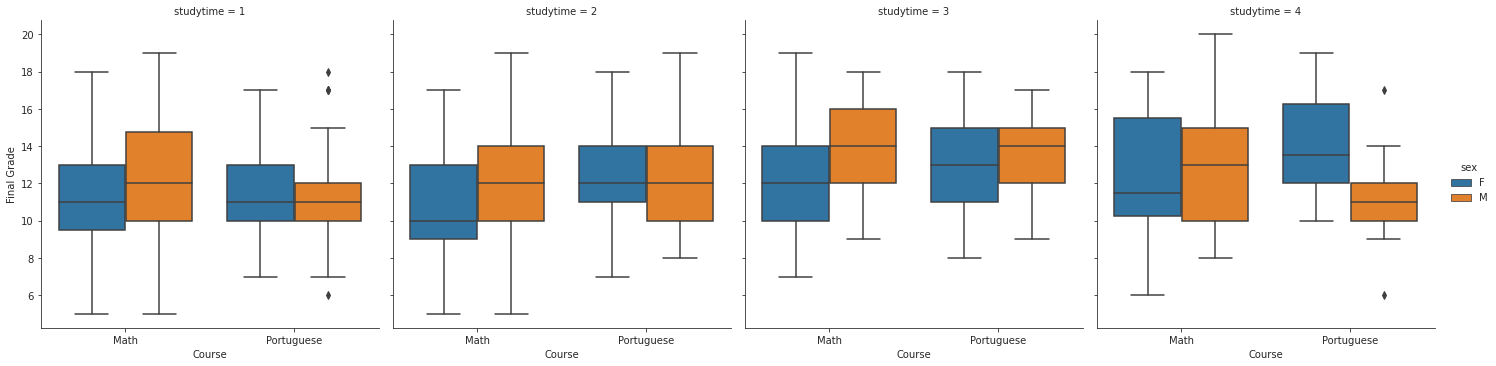

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


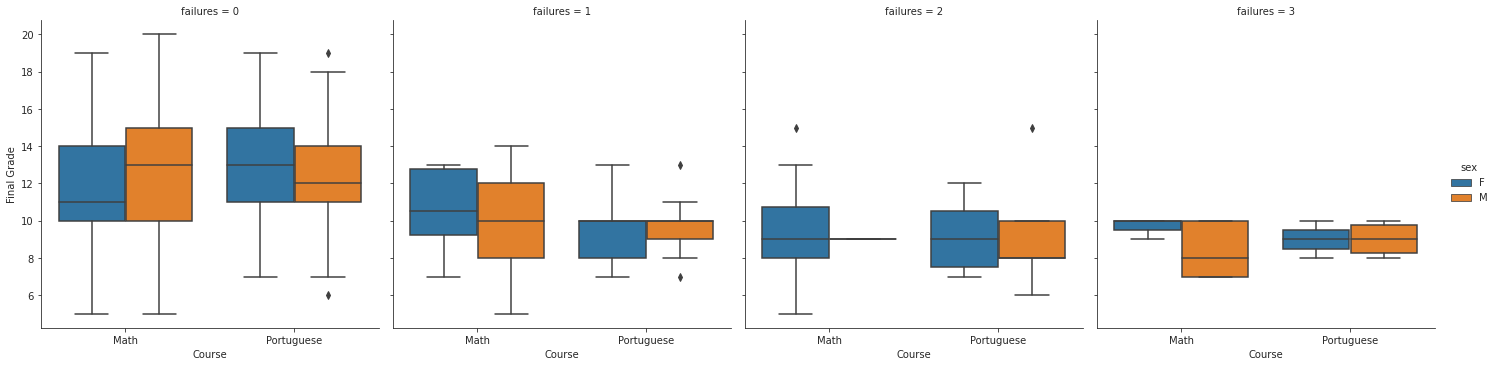

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


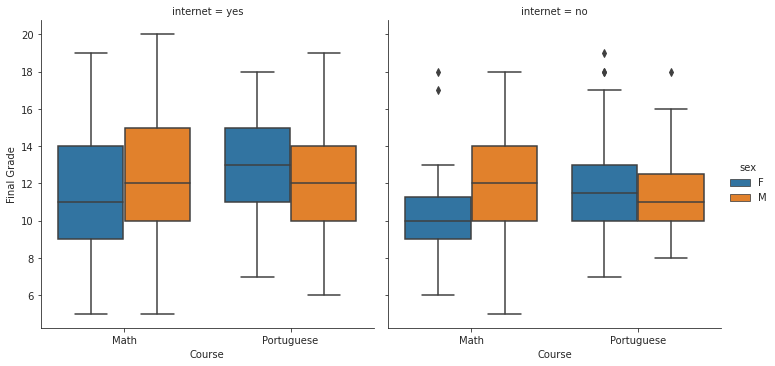




*** Pair Plots


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


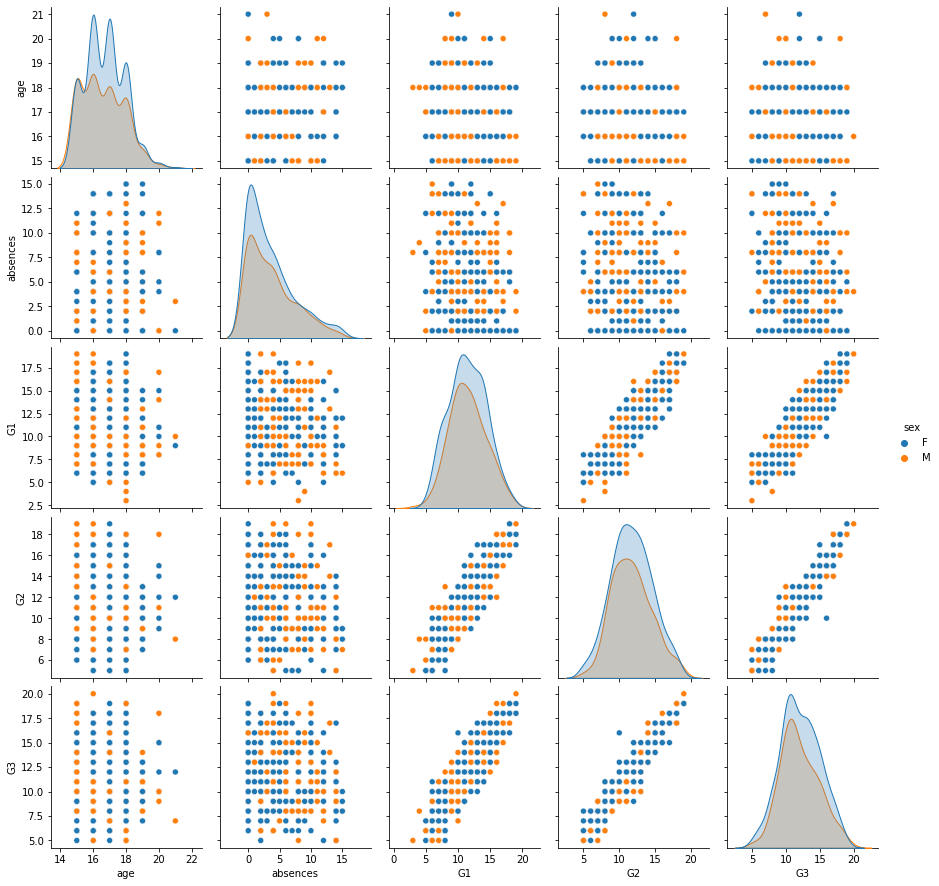



*** Correlation Matrix


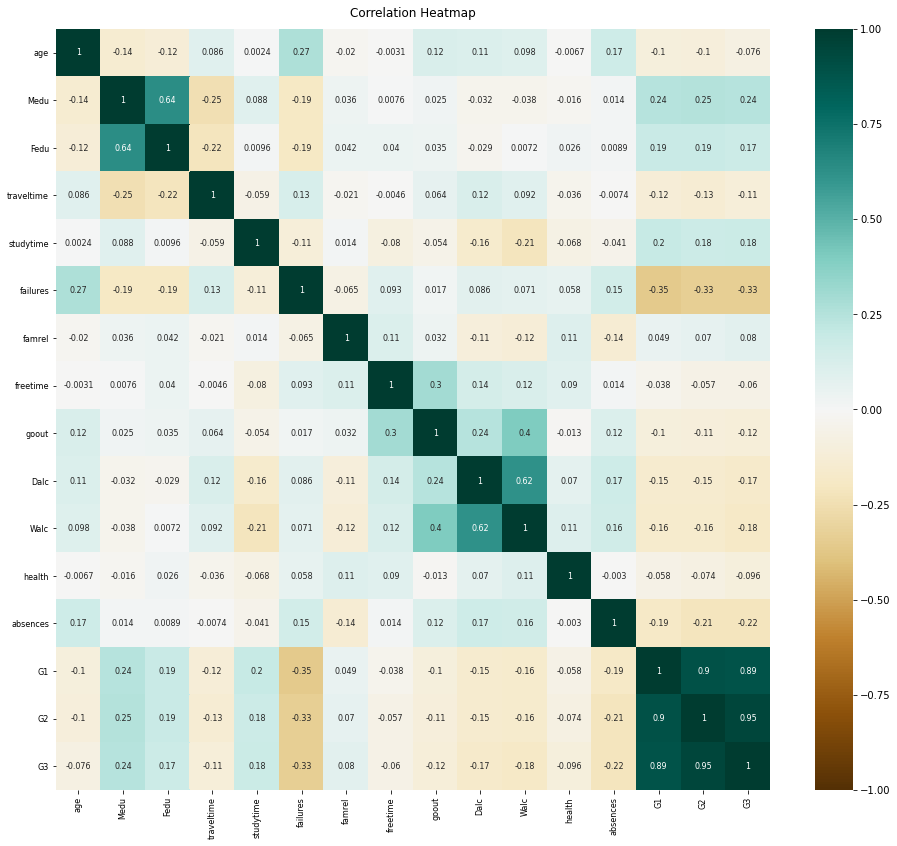



*** Box Plot of Outputs


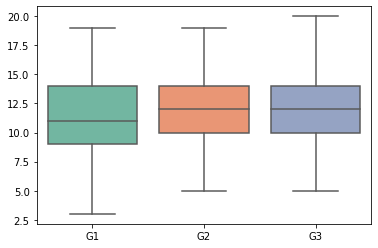

In [ ]:
### Plotting Histogram
print("*** Histogram Plot")
count = 0
n_rows = 4
n_cols = 4
fig, axes=plt.subplots(n_rows, n_cols, figsize=(16,14), sharex=False, gridspec_kw={'hspace': 0.35, 'wspace': 0.35})
for i in range(len(num_variables)):
  sns.histplot(df_student_clean[num_variables[i]], ax=axes[i//n_cols, i%n_cols])
  count += 1
plt.show()
print("\n")

### Plotting Factor Plots
print("*** Factor Plots")
## Considering Five Factors
third_factor = ["school", "address", "studytime", "failures", "internet"]
# Looping through the factors
for factor in third_factor:
  with sns.axes_style(style='ticks'):
      g = sns.factorplot(x="course", y="G3", hue="sex", col= factor, data=df_student_clean, kind="box")
      g.set_axis_labels("Course", "Final Grade");
  plt.show()
  print()
print("\n")

### Plotting Pair Plots
print("*** Pair Plots")
sns.pairplot(df_student_clean[["age", "absences", "G1", "G2", "G3","sex"]], hue='sex', size=2.5);
plt.show()
print("\n")

### Plotting Correlation Matrix
print("*** Correlation Matrix")

fig1, ax1 = plt.subplots(figsize=(16,14))
#matrix = np.triu(df.corr())
ax1 = sns.heatmap(df_student_clean.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=None, annot_kws={"size":8})
ax1.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 8, rotation=90)
ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 8, rotation=0)
plt.show()
print("\n")

### Box Plot
print("*** Box Plot of Outputs")
sns.boxplot(data=df_student_clean[["G1", "G2", "G3"]], orient="v", palette="Set2")
plt.show()
print("\n")


In [ ]:
##### INFERENTIAL STATS
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

### Perform 2k Factorial Design on the following factors (Repeated Measures ANOVA) 
# Course
# Sex
# Address
# School

df_sample = df_student_clean[["sex", "address", "school", "course", "G3"]]
print("Sample Data:\n", df_sample)
print("\n")


Sample Data:
     sex address school      course  G3
1     F       U     GP        Math   6
2     F       U     GP        Math  10
3     F       U     GP        Math  15
4     F       U     GP        Math  10
5     M       U     GP        Math  15
..   ..     ...    ...         ...  ..
644   F       R     MS  Portuguese  10
645   F       U     MS  Portuguese  16
646   F       U     MS  Portuguese   9
647   M       U     MS  Portuguese  10
648   M       R     MS  Portuguese  11

[849 rows x 5 columns]




In [ ]:

print("*** Group Means\n")
print("* Sex:\n", df_sample.groupby(["sex"]).mean())
print()
print("* School:\n", df_sample.groupby(["school"]).mean())
print("\n")
print("* Course:\n", df_sample.groupby(["course"]).mean())
print("\n")
print("* Address:\n", df_sample.groupby(["address"]).mean())
print("\n")

##### Perform Four-way ANOVA (Non-Repeated Measure)
print("*** Between Subject ANOVA")
main_factors  = 'G3 ~ C(sex) + C(address) + C(school) + C(course) + ' 
two_way_int   = 'C(sex):C(address) + C(sex):C(school) + C(sex):C(course) + C(address):C(school) + C(address):C(course) + C(school):C(course) + '
three_way_int = 'C(sex):C(address):C(school) + C(sex):C(address):C(course) + C(sex):C(school):C(course) + C(address):C(school):C(course) + '
four_way_int  = 'C(sex):C(address):C(school):C(course)'

formula = main_factors + two_way_int + three_way_int + four_way_int

model = ols(formula, data=df_sample).fit()
anova_model = sm.stats.anova_lm(model, typ=2)
print(anova_model)



# ##### Perform Four-way ANOVA (Repeated Measure)
# from statsmodels.stats.anova import AnovaRM
# model_rm = AnovaRM(data=df_sample, depvar='G3', subject='None', within=['course']).fit()
# print(model_rm)



*** Group Means

* Sex:
             G3
sex           
F    12.101240
M    12.030137

* School:
                G3
school           
GP      12.412752
MS      11.264822


* Course:
                    G3
course               
Math        11.754902
Portuguese  12.248619


* Address:
                 G3
address           
R        11.572034
U        12.262643


*** Between Subject ANOVA
                                            sum_sq  ...        PR(>F)
C(sex)                                    2.573504  ...  5.612479e-01
C(address)                               16.498130  ...  1.414998e-01
C(school)                               265.076711  ...  5.320177e-09
C(course)                               124.116400  ...  5.927758e-05
C(sex):C(address)                         6.203719  ...  3.670978e-01
C(sex):C(school)                          2.992297  ...  5.310063e-01
C(sex):C(course)                        116.407274  ...  1.001941e-04
C(address):C(school)                      0.233620  

In [ ]:
signif = []
for i in anova_model.iloc[:, 3]:
  if(i < 0.05):
    signif.append("True")
  else:
    signif.append("False")
anova_model["signficant"]=signif

In [ ]:
anova_model

,sum_sq,df,F,PR(>F),signficant
C(sex),2.573504,1.0,0.337819,5.612479e-01,False
C(address),16.498130,1.0,2.165681,1.414998e-01,False
C(school),265.076711,1.0,34.796156,5.320177e-09,True
C(course),124.116400,1.0,16.292543,5.927758e-05,True
C(sex):C(address),6.203719,1.0,0.814351,3.670978e-01,False
C(sex):C(school),2.992297,1.0,0.392794,5.310063e-01,False
C(sex):C(course),116.407274,1.0,15.280579,1.001941e-04,True
C(address):C(school),0.233620,1.0,0.030667,8.610281e-01,False
C(address):C(course),6.333122,1.0,0.831338,3.621498e-01,False
C(school):C(course),11.848390,1.0,1.555317,2.127027e-01,False


*** Plotting Residuals



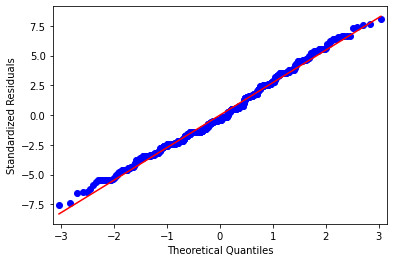



*** Two-way Interaction



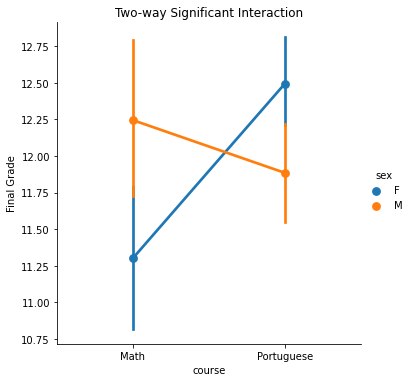



*** Three-way Significant Interaction



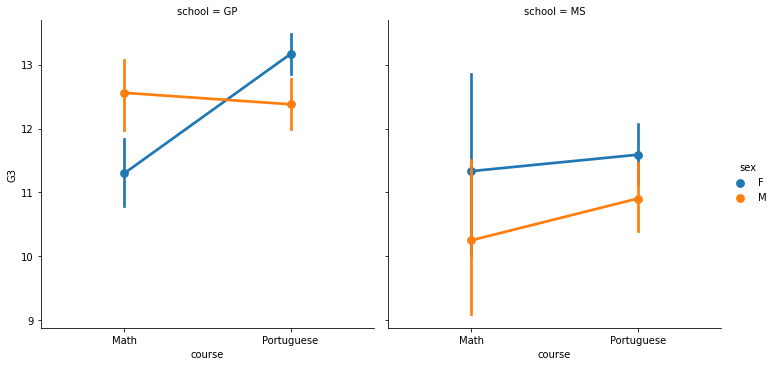

In [ ]:
### Ploting the Residuals
print("*** Plotting Residuals\n")
res = model.resid
sm.qqplot(res, line='s')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()
print("\n")

### Plotting the Interactions
# Two-way interaction
print("*** Two-way Interaction\n")
g = sns.catplot(x="course", y="G3", hue="sex",
                kind= "point", data=df_sample)
plt.title("Two-way Significant Interaction")
plt.ylabel("Final Grade")
plt.show()
print("\n")

# Three-way Interaction
print("*** Three-way Significant Interaction\n")
g = sns.catplot(x="course", y="G3", hue="sex",
                col="school", kind= "point", data=df_sample)
plt.show()

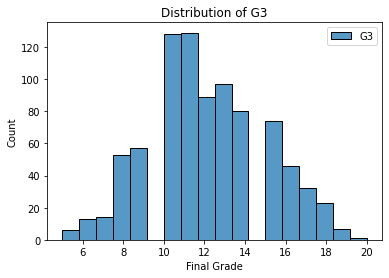

NormaltestResult(statistic=11.934075861821647, pvalue=0.002561818474888021)
G3 is not normally distributed.


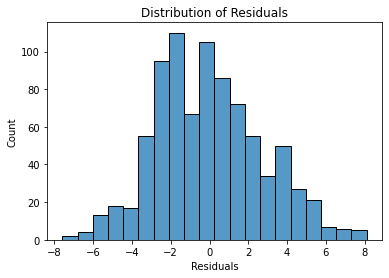

NormaltestResult(statistic=11.934075861821647, pvalue=0.002561818474888021)
The residuals are not normally distributed.


In [ ]:
### Perform Assumption Checks before the Factorial Design

# We can assume independence in our observations. The performance of one student should not determine the performance of another student.
# However, there may be latent variables (such as student participation) which could influence student performance.

# Normality of Dependent Variable
sns.histplot(df_sample[["G3"]])
plt.xlabel("Final Grade")
plt.title("Distribution of G3")
plt.show()
print(stats.normaltest(df_sample["G3"]))
print("G3 is not normally distributed.")

# Heteroskedasticity (Variance Checks)
sns.histplot(res)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()


import scipy.stats as stats
print(stats.normaltest(df_sample["G3"]))
print("The residuals are not normally distributed.")




In [ ]:
print("*** Between Subject ANOVA")
main_factors  = 'G3 ~ C(sex) + C(address) + C(school) + C(course) + ' 
two_way_int   = 'C(sex):C(address) + C(sex):C(school) + C(sex):C(course) + C(address):C(school) + C(address):C(course) + C(school):C(course) + '
three_way_int = 'C(sex):C(address):C(school) + C(sex):C(address):C(course) + C(sex):C(school):C(course) + C(address):C(school):C(course) + '
four_way_int  = 'C(sex):C(address):C(school):C(course)'
formula = main_factors + two_way_int + three_way_int + four_way_int

model = ols(formula, data=df_sample).fit()
anova_model = sm.stats.anova_lm(model, typ=2, robust="hc0")
anova_model

*** Between Subject ANOVA


,sum_sq,df,F,PR(>F)
C(sex),30.932533,1.0,4.060459,4.421937e-02
C(address),23.144887,1.0,3.038189,8.169559e-02
C(school),294.265145,1.0,38.627671,8.098589e-10
C(course),133.068556,1.0,17.467677,3.231254e-05
C(sex):C(address),9.526967,1.0,1.250588,2.637625e-01
C(sex):C(school),2.230662,1.0,0.292815,5.885668e-01
C(sex):C(course),111.762427,1.0,14.670858,1.376199e-04
C(address):C(school),0.606684,1.0,0.079638,7.778583e-01
C(address):C(course),6.469709,1.0,0.849267,3.570265e-01
C(school):C(course),6.686081,1.0,0.877670,3.491121e-01


In [ ]:
signif = []
for i in anova_model.iloc[:, 3]:
  if(i < 0.05):
    signif.append("True")
  else:
    signif.append("False")
anova_model["signficant"]=signif
anova_model

,sum_sq,df,F,PR(>F),signficant
C(sex),30.932533,1.0,4.060459,4.421937e-02,True
C(address),23.144887,1.0,3.038189,8.169559e-02,False
C(school),294.265145,1.0,38.627671,8.098589e-10,True
C(course),133.068556,1.0,17.467677,3.231254e-05,True
C(sex):C(address),9.526967,1.0,1.250588,2.637625e-01,False
C(sex):C(school),2.230662,1.0,0.292815,5.885668e-01,False
C(sex):C(course),111.762427,1.0,14.670858,1.376199e-04,True
C(address):C(school),0.606684,1.0,0.079638,7.778583e-01,False
C(address):C(course),6.469709,1.0,0.849267,3.570265e-01,False
C(school):C(course),6.686081,1.0,0.877670,3.491121e-01,False


Categorical Variables:
     school      course sex address  ... nursery higher internet romantic
1       GP        Math   F       U  ...      no    yes      yes       no
2       GP        Math   F       U  ...     yes    yes      yes       no
3       GP        Math   F       U  ...     yes    yes      yes      yes
4       GP        Math   F       U  ...     yes    yes       no       no
5       GP        Math   M       U  ...     yes    yes      yes       no
..     ...         ...  ..     ...  ...     ...    ...      ...      ...
644     MS  Portuguese   F       R  ...      no    yes      yes       no
645     MS  Portuguese   F       U  ...     yes    yes      yes       no
646     MS  Portuguese   F       U  ...     yes    yes       no       no
647     MS  Portuguese   M       U  ...      no    yes      yes       no
648     MS  Portuguese   M       R  ...      no    yes      yes       no

[849 rows x 18 columns]
Categorical Columns: 45


Final Encoded Dataset:
      school_GP  school_MS

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


No request for ICA Details.

ICA Data:
      Component_1  Component_2  ...  Component_9  D_Variable
0       0.016876     0.017656  ...    -0.022149         6.0
1       0.004380     0.049214  ...     0.034507        10.0
2      -0.034249    -0.045815  ...    -0.046143        15.0
3      -0.037654     0.009746  ...     0.046791        10.0
4      -0.045848     0.045706  ...     0.021414        15.0
..           ...          ...  ...          ...         ...
844    -0.024853    -0.015720  ...     0.008041        10.0
845     0.064450    -0.015103  ...     0.018679        16.0
846    -0.015520    -0.078823  ...     0.013697         9.0
847     0.037454     0.011481  ...     0.015913        10.0
848    -0.025681     0.004423  ...     0.026730        11.0

[849 rows x 10 columns]


No request for UFS Details.

UFS Data:
       G2   G1  failures  higher_yes  higher_no  Medu  D_Variable
0    0.0  1.0       1.0         0.0        5.0   5.0         6.0
1    0.0  1.0       1.0         3.0        

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

Results:
   Algorithm      Mean       STD
0       KNN  0.847110  0.043468
1        NB  0.899881  0.048103
2       SVM  0.896920  0.044957
3        GB  0.894162  0.038298
4        AB  0.879583  0.044148
5        RF  0.889580  0.040424
6        LR  0.898605  0.047963




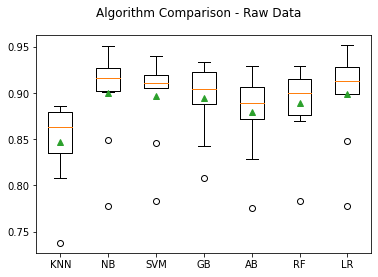



*** UFS Data Model


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

Results:
   Algorithm      Mean       STD
0       KNN  0.874271  0.049013
1        NB  0.901496  0.040069
2       SVM  0.898242  0.039061
3        GB  0.893891  0.036257
4        AB  0.875822  0.038196
5        RF  0.878769  0.040981
6        LR  0.901470  0.040070




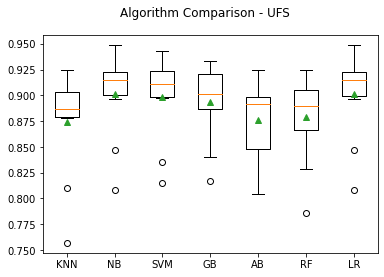



*** PCA Data Model


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

Results:
   Algorithm      Mean       STD
0       KNN  0.848787  0.043369
1        NB  0.899769  0.051210
2       SVM  0.875287  0.041453
3        GB  0.840368  0.051881
4        AB  0.829383  0.054487
5        RF  0.860182  0.059379
6        LR  0.899510  0.051567




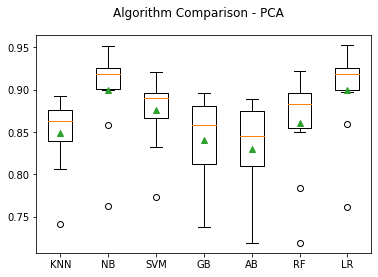



*** ICA Data Model


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

Results:
   Algorithm      Mean       STD
0       KNN  0.704676  0.038457
1        NB  0.897557  0.046100
2       SVM  0.826053  0.040852
3        GB  0.747190  0.061429
4        AB  0.768995  0.064293
5        RF  0.811058  0.059161
6        LR  0.897544  0.046152




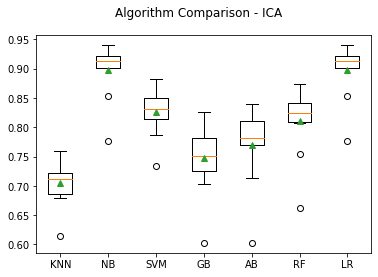

In [ ]:
##### PREDICTIVE MODELING WITH MACHINE LEARNING ALGORITHMS
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score
from matplotlib import pyplot

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor

# Create an ML model with two outputs (both discrete and continuous) that are directly related.
# Create a pipeline that will integrate the ML algorithms and the Feature-engineered input and output
# Tune the models' hyper-parameter
# Optimize based on the features selected and the algorithm parameters
# Perform Y-scrambling to validate the models' performance against pure-chance

df_student_cat = df_student_clean.select_dtypes(include=[object])
df_student_num = df_student_clean.select_dtypes(include=[int])
print("Categorical Variables:\n", df_student_cat)
# print()
# print("Numeric Variables:\n", df_student_num)

# creating column names for OneHot Encoder
cat_col_names = []
for k, v in col_unique_vals.items():
  cat_col_names.extend([f"{k}_{val}" for val in v])

print("Categorical Columns:", len(cat_col_names))
print("\n")

### Label Encoder
le = preprocessing.LabelEncoder()
df_student_LE = df_student_cat.apply(le.fit_transform)
# print("Label Encoder:\n", df_student_LE)
# print()

### One Hot Encoder
enc = preprocessing.OneHotEncoder()
enc.fit(df_student_cat)
onehotlabels = enc.transform(df_student_cat).toarray()

# Create Dataframe
df_onhot_cat = pd.DataFrame(onehotlabels, columns=cat_col_names)
# print("OneHot Dataset:\n", df_onhot_cat)
# print("\n")

# Integrate Datasets
df_student_enc = pd.merge(df_onhot_cat, df_student_num, how="inner", on=[df_onhot_cat.index])
df_student_enc.drop(columns=["key_0"], inplace=True)
print("Final Encoded Dataset:\n", df_student_enc)
print("\n")

# PCA-Transformed Data
df_pca = feature_engineering(df_student_enc, n_features= 20, transform='PCA', score_fn=f_regression, details='no')
print("PCA Data:\n", df_pca)
print("\n")

# ICA-Transformed Data
df_ica = feature_engineering(df_student_enc, n_features= 9, transform='ICA', score_fn=f_regression, details='no')
print("ICA Data:\n", df_ica)
print("\n")

# UFS Data
df_ufs = feature_engineering(df_student_enc, n_features= 6, transform='UFS', score_fn=f_regression, details='no')
print("UFS Data:\n", df_ufs)
print("\n")


# Function for ML Model
def ml_model(dataframe, label="Data"):
  ### Creating Pipeline Models
  array = dataframe.values
  X = array[:, :len(dataframe.columns) -1]
  Y = array[:, len(dataframe.columns) -1]

  # ML Models
  models = []
  models.append(('KNN', KNeighborsRegressor()))
  #models.append(('CART', DecisionTreeRegressor()))
  models.append(('NB', BayesianRidge()))
  models.append(('SVM', SVR(C=1.0, epsilon=0.2)))
  models.append(('GB', GradientBoostingRegressor(learning_rate=0.05, n_estimators=51)))
  models.append(('AB', AdaBoostRegressor(n_estimators=51, random_state=0)))
  models.append(('RF', RandomForestRegressor()))
  models.append(('LR', LinearRegression()))

  # evaluate each model in turn
  results = []
  names = []
  scoring = 'r2'

  df_res = pd.DataFrame(columns=["Algorithm", "Mean", "STD"])
  for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
    df_res = df_res.append({"Algorithm":name, "Mean":cv_results.mean(), "STD":cv_results.std()}, ignore_index=True)
  print("Results:\n", df_res)
  print("\n")

  # boxplot algorithm comparison
  fig = pyplot.figure()
  fig.suptitle(f'Algorithm Comparison - {label}')
  ax = fig.add_subplot(111)
  pyplot.boxplot(results, showmeans=True)
  ax.set_xticklabels(names)
  pyplot.show()

### Using Raw data
print("*** Raw Data Model")
ml_model(df_student_enc, label="Raw Data")
print("\n")

print("*** UFS Data Model")
ml_model(df_ufs, label="UFS")
print("\n")

print("*** PCA Data Model")
ml_model(df_pca, label="PCA")
print("\n")

print("*** ICA Data Model")
ml_model(df_ica, label="ICA")
print("\n")








# create feature union
# features = []
# features.append(('select_best', SelectKBest(k=3)))
# features.append(('pca', PCA(n_components=6)))
# feature_union = FeatureUnion(features)
# df_feat_union = feature_union.fit_transform(X, Y)
#print("Unioned Features", df_feat_union)

# create pipeline
# estimators = []
# estimators.append(('feature_union', feature_union))
# estimators.append(('KNN', KNeighborsRegressor()))
# estimators.append(('CART', DecisionTreeRegressor()))
# estimators.append(('NB', BayesianRidge()))
# estimators.append(('SVM', SVR(C=1.0, epsilon=0.2)))
# model = Pipeline(estimators)

# evaluate pipeline
# kfold = KFold(n_splits=10, random_state=7)
# results = cross_val_score(model, X, Y, cv=kfold, scoring="r2")
# print("*** Results", results.mean())






